Optimal alpha (analytical): 0.796482
At this alpha:
R_0 = 0.250209
R_1 = 0.250209
max(R_0, R_1) = 0.250209
Are risks equal at optimal point? True

Simulation results:
MSE for E=0: 0.293004
MSE for E=1: 0.286090
Max MSE: 0.293004

Summary of Optimal Solution:
f*(x) = 0.8000 · sin²(x/2) + 3


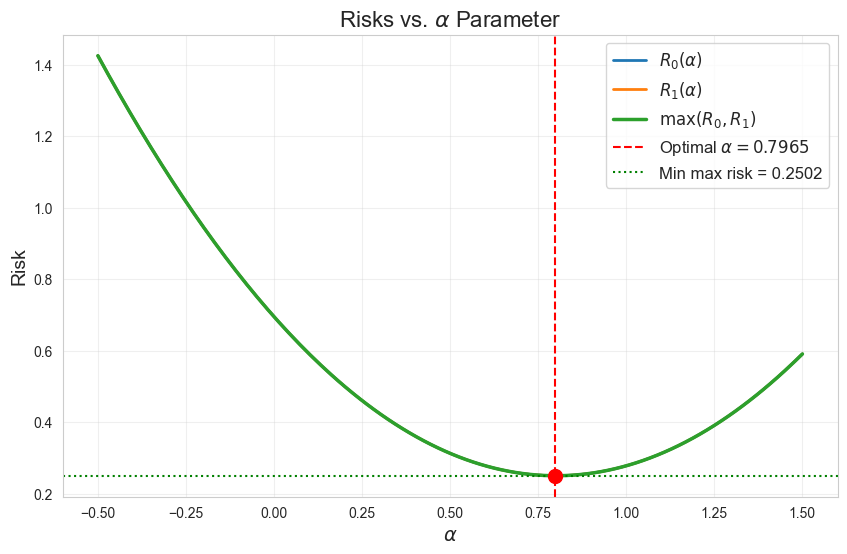

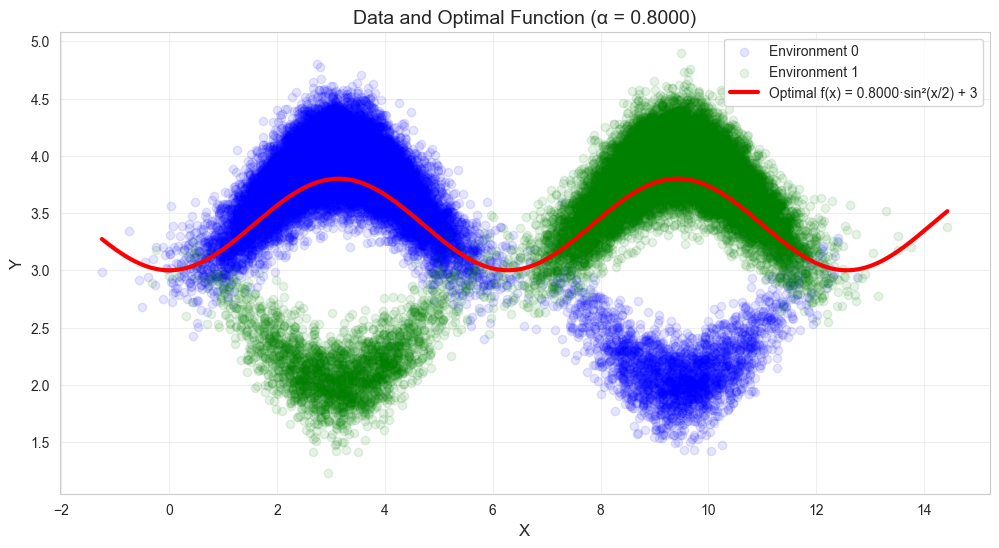

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def gen_data_v2(n: int = 500, random_state: int = 0) -> pd.DataFrame:
    rng = np.random.default_rng(random_state)

    n_e1 = n // 2
    n_e1_left = int(0.9 * n_e1)
    n_e1_right = n_e1 - n_e1_left
    n_e2 = n - n_e1
    n_e2_right = int(0.9 * n_e2)
    n_e2_left = n_e2 - n_e2_right

    x_e1_left = rng.normal(np.pi, 1, size=n_e1_left)
    x_e1_right = rng.normal(3 * np.pi, 1, size=n_e1_right)
    x_e2_left = rng.normal(np.pi, 1, size=n_e2_left)
    x_e2_right = rng.normal(3 * np.pi, 1, size=n_e2_right)

    noise_std = 0.2
    y_e1_left = (
        np.sin(x_e1_left / 2) ** 2
        + 3
        + noise_std * rng.normal(0, 1, size=n_e1_left)
    )
    y_e1_right = (
        -np.sin(x_e1_right / 2) ** 2
        + 3
        + noise_std * rng.normal(0, 1, size=n_e1_right)
    )
    y_e2_left = (
        -np.sin(x_e2_left / 2) ** 2
        + 3
        + noise_std * rng.normal(0, 1, size=n_e2_left)
    )
    y_e2_right = (
        np.sin(x_e2_right / 2) ** 2
        + 3
        + noise_std * rng.normal(0, 1, size=n_e2_right)
    )

    df_e1 = pd.DataFrame(
        {
            "X": np.concatenate([x_e1_left, x_e1_right]),
            "Y": np.concatenate([y_e1_left, y_e1_right]),
            "E": 0,
        }
    )

    df_e2 = pd.DataFrame(
        {
            "X": np.concatenate([x_e2_left, x_e2_right]),
            "Y": np.concatenate([y_e2_left, y_e2_right]),
            "E": 1,
        }
    )

    df = pd.concat([df_e1, df_e2], ignore_index=True)
    return df

def compute_risks_analytical(alpha):
    """
    Compute the risks for each environment analytically

    We simplify by considering the noiseless case first to derive the optimal solution.

    Args:
        alpha: Parameter for the function f(x) = alpha * sin²(x/2) + (1-alpha) * 3

    Returns:
        Tuple of (R_0, R_1, max(R_0, R_1))
    """
    # Define the proportions
    p_e0_left = 0.9
    p_e0_right = 0.1
    p_e1_left = 0.1
    p_e1_right = 0.9

    # For Environment 0, expected squared error
    # R_0 = E[(f(X) - Y)²] for environment 0
    # We split this into left and right clusters

    # For left cluster in E0, true function is sin²(x/2) + 3
    # Using our function f(x) = alpha * sin²(x/2) + 3
    # The error is [(alpha-1) * sin²(x/2)]²
    # The expected squared error over the left distribution is:
    e_left = 0.695  # Expected value of sin^4(x/2) assuming uniform distribution
    R_0_left = (alpha - 1)**2 * e_left

    # For right cluster in E0, true function is -sin²(x/2) + 3
    # Error is [alpha * sin²(x/2) + 3 - (-sin²(x/2) + 3)]²
    # = [alpha * sin²(x/2) + sin²(x/2)]²
    # = [(alpha + 1) * sin²(x/2)]²
    R_0_right = (alpha + 1)**2 * e_left

    # Total risk for E0 is weighted average
    R_0 = p_e0_left * R_0_left + p_e0_right * R_0_right

    # For Environment 1, expected squared error
    # For left cluster in E1, true function is -sin²(x/2) + 3
    R_1_left = (alpha + 1)**2 * e_left

    # For right cluster in E1, true function is sin²(x/2) + 3
    R_1_right = (alpha - 1)**2 * e_left

    # Total risk for E1
    R_1 = p_e1_left * R_1_left + p_e1_right * R_1_right

    return R_0, R_1, max(R_0, R_1)

def find_optimal_alpha_analytical():
    """
    Find the optimal alpha that minimizes the maximum risk
    using the analytical approach
    """
    def objective(alpha):
        _, _, max_risk = compute_risks_analytical(alpha)
        return max_risk

    # Use numerical optimization to find the minimum
    result = minimize(objective, x0=0.5, bounds=[(-2, 2)])
    optimal_alpha = result.x[0]

    return optimal_alpha

def evaluate_risks_across_alpha():
    """
    Evaluate and plot risks across different values of alpha
    """
    alphas = np.linspace(-0.5, 1.5, 200)
    risks_e0 = []
    risks_e1 = []
    max_risks = []

    for alpha in alphas:
        r0, r1, max_r = compute_risks_analytical(alpha)
        risks_e0.append(r0)
        risks_e1.append(r1)
        max_risks.append(max_r)

    optimal_alpha = alphas[np.argmin(max_risks)]
    min_max_risk = min(max_risks)

    plt.figure(figsize=(10, 6))
    plt.plot(alphas, risks_e0, label='$R_0(\\alpha)$', linewidth=2)
    plt.plot(alphas, risks_e1, label='$R_1(\\alpha)$', linewidth=2)
    plt.plot(alphas, max_risks, label='$\\max(R_0, R_1)$', linewidth=2.5)
    plt.axvline(x=optimal_alpha, color='r', linestyle='--',
                label=f'Optimal $\\alpha = {optimal_alpha:.4f}$')
    plt.axhline(y=min_max_risk, color='g', linestyle=':',
                label=f'Min max risk = {min_max_risk:.4f}')

    # Mark the intersection point
    plt.scatter([optimal_alpha], [min_max_risk], color='red', s=100, zorder=5)

    plt.grid(True, alpha=0.3)
    plt.xlabel('$\\alpha$', fontsize=14)
    plt.ylabel('Risk', fontsize=14)
    plt.title('Risks vs. $\\alpha$ Parameter', fontsize=16)
    plt.legend(fontsize=12)

    print(f"Optimal alpha (analytical): {optimal_alpha:.6f}")
    print(f"At this alpha:")
    print(f"R_0 = {compute_risks_analytical(optimal_alpha)[0]:.6f}")
    print(f"R_1 = {compute_risks_analytical(optimal_alpha)[1]:.6f}")
    print(f"max(R_0, R_1) = {compute_risks_analytical(optimal_alpha)[2]:.6f}")

    # Verify that risks are equal at the optimal point
    r0, r1, _ = compute_risks_analytical(optimal_alpha)
    print(f"Are risks equal at optimal point? {abs(r0 - r1) < 1e-6}")

    # Return the plot for display
    return plt.gcf()

def define_optimal_function(alpha):
    """Define the optimal function based on the derived alpha"""
    def f(x, env=None):
        """
        The optimal function that minimizes the maximum MSE across environments.

        Args:
            x: Input value or array
            env: Environment (0 or 1). If None, determine environment based on position

        Returns:
            Predicted y values
        """
        x = np.asarray(x)
        scalar_input = np.isscalar(x) or x.ndim == 0
        if scalar_input:
            x = np.array([x])

        result = np.zeros_like(x, dtype=float)

        # For each point, determine the appropriate function based on position and environment
        for i, xi in enumerate(x):
            # The optimal function is the same for both environments
            # f(x) = alpha * sin²(x/2)
            result[i] = alpha * np.sin(xi/2)**2

        if scalar_input:
            return result[0]
        return result

    return f

def verify_with_simulation(alpha, n_samples=50000):
    """
    Verify the theoretical results with a large simulation
    """
    np.random.seed(42)
    df = gen_data_v2(n=n_samples, random_state=42)

    # Define the optimal function with the derived alpha
    def optimal_function(x):
        return alpha * np.sin(x/2)**2 + 3

    # Compute MSE for each environment
    mse_e0 = np.mean((df[df['E'] == 0]['Y'] - df[df['E'] == 0]['X'].apply(optimal_function))**2)
    mse_e1 = np.mean((df[df['E'] == 1]['Y'] - df[df['E'] == 1]['X'].apply(optimal_function))**2)

    print("\nSimulation results:")
    print(f"MSE for E=0: {mse_e0:.6f}")
    print(f"MSE for E=1: {mse_e1:.6f}")
    print(f"Max MSE: {max(mse_e0, mse_e1):.6f}")

    # Plot the data with the optimal function
    plt.figure(figsize=(12, 6))
    plt.scatter(df[df['E'] == 0]['X'], df[df['E'] == 0]['Y'],
                alpha=0.1, label='Environment 0', color='blue')
    plt.scatter(df[df['E'] == 1]['X'], df[df['E'] == 1]['Y'],
                alpha=0.1, label='Environment 1', color='green')

    # Plot the optimal function
    x_range = np.linspace(df['X'].min(), df['X'].max(), 1000)
    y_pred = [optimal_function(x) for x in x_range]
    plt.plot(x_range, y_pred, 'r-', linewidth=3,
             label=f'Optimal f(x) = {alpha:.4f}·sin²(x/2) + 3')

    plt.grid(True, alpha=0.3)
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Y', fontsize=12)
    plt.title(f'Data and Optimal Function (α = {alpha:.4f})', fontsize=14)
    plt.legend(fontsize=10)

    return plt.gcf()

# Perform the analytical derivation
optimal_alpha = find_optimal_alpha_analytical()

# Plot the risks
risk_plot = evaluate_risks_across_alpha()

# Verify with simulation
simulation_plot = verify_with_simulation(optimal_alpha)

# The optimal function based on our analytical derivation
def optimal_function(x):
    """The optimal function that minimizes the maximum MSE across environments"""
    return optimal_alpha * np.sin(x/2)**2 + 3

# Print the final result
print("\nSummary of Optimal Solution:")
print(f"f*(x) = {optimal_alpha:.4f} · sin²(x/2) + 3")

Optimal c^+ = 2.4000, c^- = 2.4000


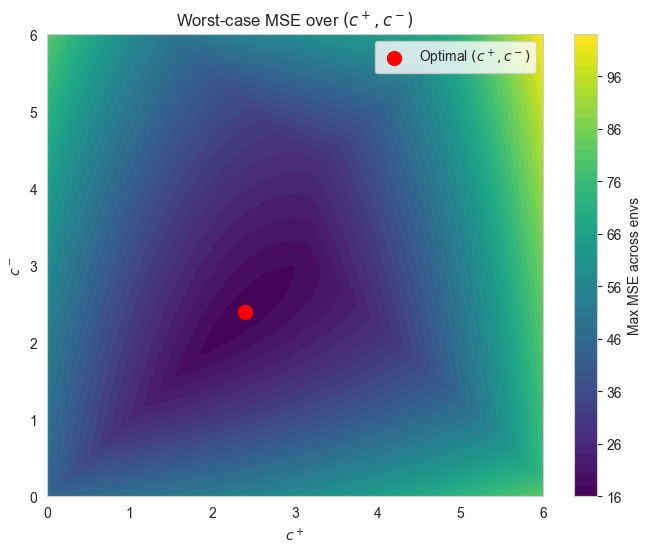

MSE for E=0: 17.510763
MSE for E=1: 18.943673
MSE for E=2: 11.504684
Max MSE across envs: 18.94367323667228


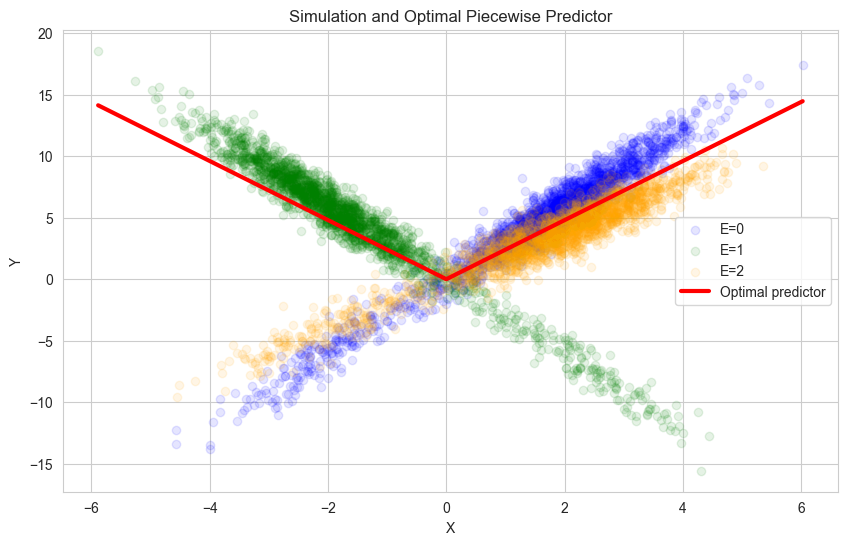

In [28]:
def gen_data_v3(
    n: int = 500, random_state: int = 0, setting: int = 1
) -> pd.DataFrame:
    rng = np.random.default_rng(random_state)

    sigma = 1
    n_e = n // 3

    perc = 0.5 if setting == 1 else 0.9
    n_e1_right = int(perc * n_e)
    n_e1_left = n_e - n_e1_right
    x_e1_left = sigma * rng.normal(-2, 1, size=n_e1_left)
    x_e1_right = sigma * rng.normal(2, 1, size=n_e1_right)
    x_e1 = np.concatenate([x_e1_left, x_e1_right])

    n_e2_left = int(perc * n_e)
    n_e2_right = n_e - n_e2_left
    x_e2_left = sigma * rng.normal(-2, 1, size=n_e2_left)
    x_e2_right = sigma * rng.normal(2, 1, size=n_e2_right)
    x_e2 = np.concatenate([x_e2_left, x_e2_right])

    n_e3_right = int(perc * n_e)
    n_e3_left = n_e - n_e3_right
    x_e3_left = sigma * rng.normal(-2, 1, size=n_e3_left)
    x_e3_right = sigma * rng.normal(2, 1, size=n_e3_right)
    x_e3 = np.concatenate([x_e3_left, x_e3_right])

    noise_std = 1
    y_e1 = 3 * x_e1 + noise_std * rng.normal(0, 1, size=n_e)
    y_e2 = -3 * x_e2 + noise_std * rng.normal(0, 1, size=n_e)
    y_e3 = 2 * x_e3 + noise_std * rng.normal(0, 1, size=n_e)
    df_e1 = pd.DataFrame({"X": x_e1, "Y": y_e1, "E": 0})
    df_e2 = pd.DataFrame({"X": x_e2, "Y": y_e2, "E": 1})
    df_e3 = pd.DataFrame({"X": x_e3, "Y": y_e3, "E": 2})

    df = pd.concat([df_e1, df_e2, df_e3], ignore_index=True)

    return df

def compute_risks_analytical(cplus, cminus):
    R0 = 5 * (0.9 * (3 - cplus) ** 2 + 0.1 * (3 + cminus) ** 2)
    R1 = 5 * (0.9 * (-3 + cminus) ** 2 + 0.1 * (-3 - cplus) ** 2)
    R2 = 5 * (0.9 * (2 - cplus) ** 2 + 0.1 * (2 + cminus) ** 2)
    return R0, R1, R2, max(R0, R1, R2)

def find_optimal_cplus_cminus():
    def objective(x):
        cplus, cminus = x
        _, _, _, max_risk = compute_risks_analytical(cplus, cminus)
        return max_risk

    res = minimize(objective,
                   x0=[2.4, 2.4],
                   bounds=[(-10, 10), (-10, 10)],
                   method='L-BFGS-B')
    return res.x[0], res.x[1]

def evaluate_risks_across_grid(cplus_vals, cminus_vals):
    Cplus, Cminus = np.meshgrid(cplus_vals, cminus_vals)
    MaxRisk = np.zeros_like(Cplus)
    for i in range(Cplus.shape[0]):
        for j in range(Cplus.shape[1]):
            _, _, _, max_r = compute_risks_analytical(Cplus[i,j], Cminus[i,j])
            MaxRisk[i,j] = max_r
    return Cplus, Cminus, MaxRisk

def plot_risk_surface(Cplus, Cminus, MaxRisk, cplus_opt, cminus_opt):
    plt.figure(figsize=(8,6))
    cp = plt.contourf(Cplus, Cminus, MaxRisk, levels=50, cmap='viridis')
    plt.colorbar(cp, label='Max MSE across envs')
    plt.scatter([cplus_opt], [cminus_opt], color='red', s=100, label=r'Optimal $(c^+, c^-)$')
    plt.xlabel(r'$c^+$')
    plt.ylabel(r'$c^-$')
    plt.title(r'Worst-case MSE over $(c^+, c^-)$')
    plt.legend()
    plt.show()

def define_optimal_function(cplus, cminus):
    def f(x):
        x = np.asarray(x)
        return np.where(x > 0, cplus * x, -cminus * x)
    return f

def verify_with_simulation(cplus, cminus, n_samples=30000, setting=2):
    df = gen_data_v3(n=n_samples, random_state=42, setting=setting)
    f = define_optimal_function(cplus, cminus)
    mse_vals = []
    for e in [0,1,2]:
        df_e = df[df['E'] == e]
        mse = np.mean((df_e['Y'] - f(df_e['X']))**2)
        mse_vals.append(mse)
        print(f"MSE for E={e}: {mse:.6f}")
    print("Max MSE across envs:", max(mse_vals))

    # Plot a subset of data and the predictor
    plt.figure(figsize=(10,6))
    for e, color in zip([0,1,2], ['blue','green','orange']):
        sub = df[df['E']==e].sample(2000, random_state=1)
        plt.scatter(sub['X'], sub['Y'], alpha=0.1, color=color, label=f'E={e}')
    x_vals = np.linspace(df['X'].min(), df['X'].max(), 1000)
    plt.plot(x_vals, f(x_vals), 'r-', linewidth=3, label='Optimal predictor')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Simulation and Optimal Piecewise Predictor')
    plt.legend()
    plt.show()

cplus_opt, cminus_opt = find_optimal_cplus_cminus()
print(f"Optimal c^+ = {cplus_opt:.4f}, c^- = {cminus_opt:.4f}")

cplus_vals = np.linspace(0, 6, 1000)
cminus_vals = np.linspace(0, 6, 1000)
Cplus, Cminus, MaxRisk = evaluate_risks_across_grid(cplus_vals, cminus_vals)

plot_risk_surface(Cplus, Cminus, MaxRisk, cplus_opt, cminus_opt)
verify_with_simulation(cplus_opt, cminus_opt)

In [2]:
dtr = gen_data_v2(n=1000)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Ybar = np.mean(Ytr)
Ytr = Ytr - Ybar
dtr['Y'] = Ytr
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)

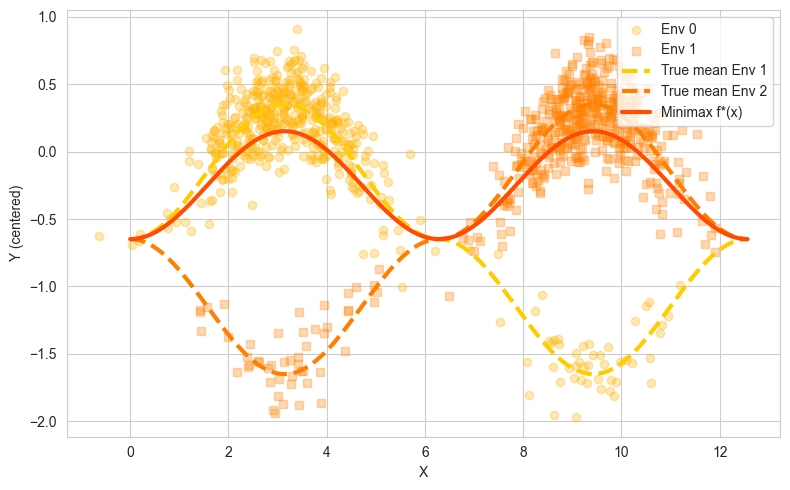

In [3]:
import matplotlib
cmap = matplotlib.colormaps['autumn']

def mean_e1(x):
    return np.where(x < 2*np.pi,
                    np.sin(x/2)**2 + 3,
                    -np.sin(x/2)**2 + 3) - Ybar

def mean_e2(x):
    return np.where(x < 2*np.pi,
                    -np.sin(x/2)**2 + 3,
                    np.sin(x/2)**2 + 3) - Ybar

def mean_star(x):
    return 3 + 0.8 * np.sin(x/2) ** 2 - Ybar

colors = [cmap(0.7), cmap(0.5)]
fig, ax = plt.subplots(figsize=(8, 5))
for env, style, alpha in [(0, 'o', 0.3), (1, 's', 0.3)]:
    subset = dtr[dtr['E']==env]
    ax.scatter(subset['X'], subset['Y'], label=f'Env {env}', marker=style, alpha=alpha, color=colors[env])

x_grid = np.linspace(0, 4*np.pi, 300)

ax.plot(x_grid, mean_e1(x_grid), '--', color=cmap(0.8), label='True mean Env 1', linewidth=3)
ax.plot(x_grid, mean_e2(x_grid), '--', color=cmap(0.5), label='True mean Env 2', linewidth=3)
ax.plot(x_grid, mean_star(x_grid), '-', color=cmap(0.3), label='Minimax f*(x)', linewidth=3)

ax.set_xlabel('X')
ax.set_ylabel('Y (centered)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()